In [ ]:
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import random
import math
import os
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional.conv2d_transpose import Conv2DTranspose
from keras.layers.reshaping.up_sampling2d import UpSampling2D
from sklearn.preprocessing import StandardScaler
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
print("Tensorflow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

Tensorflow Version: 2.11.0
Num GPUs Available:  0
[]


In [ ]:
wandb.login()

wandb: Currently logged in as: agoh (cuzime). Use `wandb login --relogin` to force relogin


True

## Toy Dataset

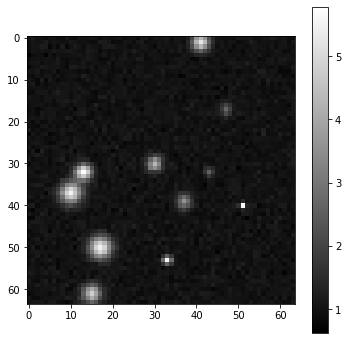

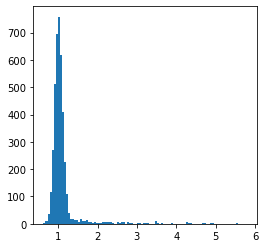

In [ ]:
def make_image(shape, noise_mean = 1,
                        noise_std = 1,
                        num_obj_min = 1,
                        num_obj_max = 20,
                        amp_min = 1,
                        amp_max = 5,
                        size_min = 0.4,
                        size_max = 1.5):
    rows = shape[0]
    cols = shape[1]

    # add noise
    noise_layer = np.random.normal(loc = noise_mean, scale = noise_std, size = shape)
    image = noise_layer

    num_obj = np.random.randint(num_obj_min, num_obj_max)

    for i in range(num_obj):
        sigma = np.random.uniform(size_min,size_max)
        amp = np.random.uniform(amp_min,amp_max)
        x0, y0 = np.random.randint(0, rows), np.random.randint(0, cols)
        x, y = np.meshgrid(np.arange(cols), np.arange(rows))
        gaussian = amp*np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

        image += gaussian

    image = np.array(image).reshape(shape[0], shape[1],1)
    return image

# VISUALIZE

# init some variables
shape = (64,64)
noise_mean = 1
noise_std = 0.1
num_obj_min = 0
num_obj_max = 20
amp_min = 1
amp_max = 5
size_min = 0.4
size_max = 2


# test plot
image = make_image(shape = shape,
                    noise_mean = noise_mean,
                    noise_std = noise_std,
                    num_obj_min = num_obj_min,
                    num_obj_max = num_obj_max,
                    amp_min = amp_min,
                    amp_max = amp_max,
                    size_min = size_min,
                    size_max = size_max)

plt.figure(figsize = (6,6))
plt.imshow(image.reshape(shape[0], shape[1]), cmap = 'gray')
plt.colorbar()

# histogram
image_flatten = np.array(image).flatten()
np.shape(image_flatten)
plt.figure(figsize = (4,4))
histogram = plt.hist(image_flatten, density = False, bins = 100)

# batches
def make_image_batch(batch_size,
                    shape,
                    noise_mean,
                    noise_std,
                    num_obj_min,
                    num_obj_max,
                    amp_min,
                    amp_max,
                    size_min,
                    size_max):
    images = []
    for i in range(batch_size):
        image = make_image(shape, noise_mean, noise_std, num_obj_min, num_obj_max, amp_min, amp_max, size_min, size_max)
        images.append(image)

    return np.array(images)

In [ ]:
# load toy images into memory

# set noise/object parameters
noise_mean = 1
noise_std = 0.1
num_obj_min = 0
num_obj_max = 20
amp_min = 1
amp_max = 5
size_min = 0.4
size_max = 2

# set image size
shape = (64,64)
input_shape = (shape[0],shape[1],1)

# set num images
num_imgs = 40000

synth_imgs = make_image_batch(batch_size=num_imgs,
                                shape=shape,
                                noise_mean=noise_mean,
                                noise_std=noise_std,
                                num_obj_min=num_obj_min,
                                num_obj_max=num_obj_max,
                                amp_min=amp_min,
                                amp_max=amp_max,
                                size_min=size_min,
                                size_max=size_max)
print(np.shape(synth_imgs))


(40000, 64, 64, 1)


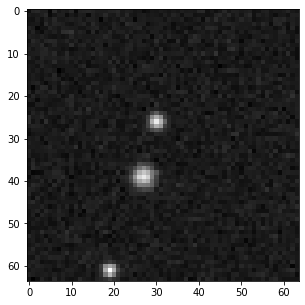

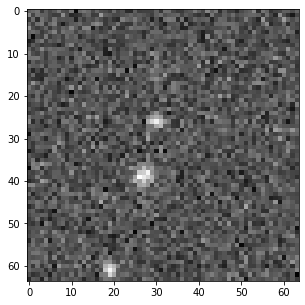

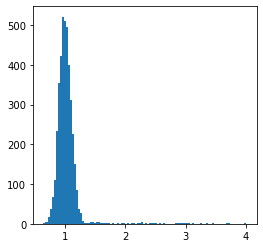

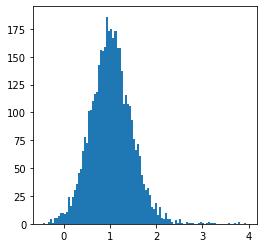

In [ ]:
# add NOISE to dataset
noise_factor_min = 0
noise_factor_max = 1.0
scale = 1.0

def add_noise(images, noise_factor_min, noise_factor_max, scale):

  shape = images.shape
  noisy_images = images.copy()
  for i in range(len(images)):
    noise_factor = random.uniform(noise_factor_min, noise_factor_max)
    noisy_images[i] = noisy_images[i] + noise_factor * np.random.normal(
          loc=0.0, scale=scale, size=(shape[1], shape[2], shape[3]))

  return noisy_images

synth_imgs_noisy = add_noise(synth_imgs, noise_factor_min = noise_factor_min, noise_factor_max=noise_factor_max, scale = scale)


# plot image + noisy_image
index = random.randint(0, len(synth_imgs)-1)

clean_image = synth_imgs[index]
noisy_image = synth_imgs_noisy[index]

plt.figure(figsize = (5,5))
plt.imshow(clean_image.reshape(shape[0], shape[1]), cmap = 'gray')
plt.figure(figsize = (5,5))
plt.imshow(noisy_image.reshape(shape[0], shape[1]), cmap = 'gray')

# histogram clean
image_flatten = np.array(clean_image).flatten()
np.shape(image_flatten)
plt.figure(figsize = (4,4))
histogram = plt.hist(image_flatten, density = False, bins = 100)

# histogram noisy
image_flatten = np.array(noisy_image).flatten()
np.shape(image_flatten)
plt.figure(figsize = (4,4))
histogram = plt.hist(image_flatten, density = False, bins = 100)

In [ ]:
# sklearn standard scaler clean_imgs
synth_imgs = synth_imgs
flattened_synth_imgs = np.reshape(synth_imgs, (num_imgs, shape[0]*shape[1]))
scaler = StandardScaler()
scaler.fit(flattened_synth_imgs)
synth_imgs_scaled = scaler.transform(flattened_synth_imgs)
synth_imgs_scaled = np.reshape(synth_imgs_scaled, (num_imgs,shape[0],shape[1],1))

synth_train = synth_imgs_scaled[0:int(num_imgs*0.9)]
synth_test = synth_imgs_scaled[int(num_imgs*0.9):]
print(np.shape(synth_train))
print(np.shape(synth_test))

# sklearn standard scaler noisy_imgs
synth_imgs_noisy = synth_imgs_noisy
flattened_synth_imgs_noisy = np.reshape(synth_imgs_noisy, (num_imgs, shape[0]*shape[1]))
scaler_noisy = StandardScaler()
scaler_noisy.fit(flattened_synth_imgs_noisy)
synth_imgs_scaled_noisy = scaler_noisy.transform(flattened_synth_imgs_noisy)
synth_imgs_scaled_noisy = np.reshape(synth_imgs_scaled_noisy, (num_imgs,shape[0],shape[1],1))

synth_train_noisy = synth_imgs_scaled_noisy[0:int(num_imgs*0.9)]
synth_test_noisy = synth_imgs_scaled_noisy[int(num_imgs*0.9):]
print(np.shape(synth_train_noisy))
print(np.shape(synth_test_noisy))

# data generator
def generate_synth_batch(batch_size):
    while True:
        synth_imgs = make_image_batch(batch_size=batch_size,
                                shape=shape,
                                noise_mean=noise_mean,
                                noise_std=noise_std,
                                num_obj_min=num_obj_min,
                                num_obj_max=num_obj_max,
                                amp_min=amp_min,
                                amp_max=amp_max,
                                size_min=size_min,
                                size_max=size_max)

        flattened_synth_imgs = np.reshape(synth_imgs, (batch_size, shape[0]*shape[1]))
        synth_imgs_scaled = scaler.transform(flattened_synth_imgs)
        synth_imgs_scaled = np.reshape(synth_imgs_scaled, (batch_size,shape[0],shape[1],1))

        synth_imgs_noisy = add_noise(synth_imgs, noise_factor_min = noise_factor_min, noise_factor_max=noise_factor_max, scale = scale)
        flattened_synth_imgs_noisy = np.reshape(synth_imgs_noisy, (batch_size, shape[0]*shape[1]))
        synth_imgs_scaled_noisy = scaler_noisy.transform(flattened_synth_imgs_noisy)
        synth_imgs_scaled_noisy = np.reshape(synth_imgs_scaled_noisy, (batch_size,shape[0],shape[1],1))

        yield ([synth_imgs_scaled_noisy], [synth_imgs_scaled])

(36000, 64, 64, 1)
(4000, 64, 64, 1)
(36000, 64, 64, 1)
(4000, 64, 64, 1)


## Fully Convolutional Autoencoder (no tuning)

In [ ]:
# GAE
def create_mask(codes_shape, comp_param):
    comp_param = comp_param
    codes_shape = codes_shape
    ones = tf.ones((codes_shape[0], codes_shape[1], comp_param))
    zeros = tf.zeros((codes_shape[0], codes_shape[1], codes_shape[2]-comp_param))
    mask = tf.concat([ones, zeros], axis = 2)
    mask = tf.reshape(mask, (1, codes_shape[0], codes_shape[1], codes_shape[2]))

    return mask

class GAE(keras.Model):

    def gae_compile(self,
                    encoder,
                    mean_model,
                    var_model,
                    encoder_optimizer,
                    mean_optimizer,
                    var_optimizer,
                    epsilon=1,
                    encoding_dim = 64,
                    beta = 1,
                    **kwargs):
        super().compile()
        self.mean_optimizer = mean_optimizer
        self.var_optimizer = var_optimizer
        self.encoder_optimizer = encoder_optimizer
        self.mle_loss_tracker = keras.metrics.Mean(name="mle_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name ="kl_loss")
        self.var_loss_tracker = keras.metrics.Mean(name="var_loss")
        self.mse_tracker = keras.metrics.Mean(name = "mse")
        self.beta = beta
        self.epsilon = epsilon
        self.mean_model = mean_model
        self.var_model = var_model
        self.encoder = encoder
        self.encoding_dim = encoding_dim

    def train_step(self, data):
        noisy_images, images = data

        """"FULLY CONV MODEL WITHOUT TUNING"""
        with tf.GradientTape(persistent = True) as tape:
            # forward pass mean
            codes = self.encoder(noisy_images, training = True)
            """"masking process"""
            #codes_shape = K.int_shape(codes)[1:]
            #comp_param = random.randint(1,64)
            #mask = create_mask(codes_shape = codes_shape, comp_param = comp_param)
            #codes = tf.multiply(codes, mask)

            mean_img = self.mean_model(codes, training = True)
            """Calculate MSE loss"""
            mse = K.mean(K.square(mean_img - images))

        # apply gradients to mean model
        mean_grads = tape.gradient(mse, self.mean_model.trainable_weights)
        encoder_grads = tape.gradient(mse, self.encoder.trainable_weights)
        self.encoder_optimizer.apply_gradients(zip(encoder_grads, self.encoder.trainable_weights))
        self.mean_optimizer.apply_gradients(zip(mean_grads, self.mean_model.trainable_weights))

        with tf.GradientTape(persistent = True) as tape:
            # forward pass variance
            codes = self.encoder(noisy_images, training = True)
            """"masking process"""
            #codes_shape = K.int_shape(codes)[1:]
            #comp_param = random.randint(1,64)
            #mask = create_mask(codes_shape = codes_shape, comp_param = comp_param)
            #codes = tf.multiply(codes, mask)

            var_img = self.var_model(codes, training = True)
            mean_img = self.mean_model(codes, training = False)
            """Calulate MLE loss"""
            mle_loss = K.log(var_img+self.epsilon) + K.square(mean_img - images) / (var_img+self.epsilon)
            mle_loss = K.mean(mle_loss)

            """Calculate KL loss of Z score"""
            z_score_img = (mean_img - images) / (var_img+self.epsilon)
            z_mean = K.mean(z_score_img, axis=[1,2], keepdims=False)
            z_log_var = 2*K.log(K.std(z_score_img, axis = [1,2], keepdims=False))
            kl_loss = -0.5 * (1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
            kl_loss = K.mean(kl_loss)

            "Variance Loss"
            var_loss = self.beta*kl_loss + mle_loss

        # apply gradients to var model
        var_grads = tape.gradient(var_loss, self.var_model.trainable_weights)
        # encoder_grads = tape.gradient(var_loss, self.encoder.trainable_weights)
        # self.encoder_optimizer.apply_gradients(zip(encoder_grads, self.encoder.trainable_weights))
        self.var_optimizer.apply_gradients(zip(var_grads, self.var_model.trainable_weights))

        # update state of trackers
        self.mle_loss_tracker.update_state(mle_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.var_loss_tracker.update_state(var_loss)
        self.mse_tracker.update_state(mse)

        return {
            "mse": self.mse_tracker.result(),
            "var_loss": self.var_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "mle_loss": self.mle_loss_tracker.result()
        }

    def test_step(self, data):

        noisy_images, images = data

        # forward pass
        codes = self.encoder(noisy_images, training = False)
        """"masking process"""
        #codes_shape = K.int_shape(codes)[1:]
        #comp_param = random.randint(1,64)
        #mask = create_mask(codes_shape = codes_shape, comp_param = comp_param)
        #codes = tf.multiply(codes, mask)

        mean_img = self.mean_model(codes, training = False)
        var_img = self.var_model(codes, training = False)

        """Calculate MSE loss"""
        mse = K.mean(K.square(mean_img - images))

        """"Calculate MLE loss"""
        mle_loss = K.log(var_img+self.epsilon) + K.square(mean_img - images) / (var_img+self.epsilon)
        mle_loss = K.mean(mle_loss)

        """Calculate KL loss of Z score"""
        z_score_img = (mean_img - images) / (var_img+self.epsilon)
        z_mean = K.mean(z_score_img, axis=[1,2], keepdims=False)
        z_log_var = 2*K.log(K.std(z_score_img, axis = [1,2], keepdims=False))
        kl_loss = -0.5 * (1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
        kl_loss = K.mean(kl_loss)

        "Variance Loss"
        var_loss = self.beta*kl_loss + mle_loss

        self.mse_tracker.reset_states()
        self.mle_loss_tracker.reset_states()
        self.var_loss_tracker.reset_states()
        self.kl_loss_tracker.reset_states()
        self.kl_loss_tracker.update_state(kl_loss)
        self.mse_tracker.update_state(mse)
        self.mle_loss_tracker.update_state(mle_loss)
        self.var_loss_tracker.update_state(var_loss)

        return {
            "mse": self.mse_tracker.result(),
            "var_loss": self.var_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "mle_loss": self.mle_loss_tracker.result()
        }

    def custom_predict(self, data, comp_param):
        x = data
        # forward pass
        codes = self.encoder(x, training = False)
        """"masking process"""
        codes_shape = K.int_shape(codes)[1:]
        comp_param = comp_param
        mask = create_mask(codes_shape = codes_shape, comp_param = comp_param)
        codes = tf.multiply(codes, mask)

        mean_img = self.mean_model(codes, training = False)
        var_img = self.var_model(codes, training = False)

        return mean_img, var_img


In [ ]:
# set hyperparameters
encoding_dim = 128
epochs = 30
batch_size = 64
steps_per_epoch = 1000
encoding_filters = [128, 64, 16]
decoding_filters = [64, 128, 256]
encoding_dense = []
decoding_dense = []
learning_rate = 0.0005
epsilon = noise_std**2
beta = 0

""""
- 1 encoder, 2 decoders for mean and variance image predictions
- fully Convolutional model will use hybrid loss, no need to specify encoding_dim
"""

# autoencoder architecture

with tf.device(device_name = '/device:GPU:0'):

    input = keras.Input(shape = input_shape)
    enc_layer = input

    # encoder
    for filter in encoding_filters:
        enc_layer = keras.layers.Conv2D(filter, (3,3), activation = 'relu', padding = 'same')(enc_layer)
        enc_layer = keras.layers.BatchNormalization()(enc_layer)
        enc_layer = keras.layers.MaxPooling2D((2,2), padding = 'same')(enc_layer)

    shape_before_flatten = K.int_shape(enc_layer)[1:]

    mean_layer = enc_layer

    for filter in decoding_filters:
        mean_layer = keras.layers.Conv2DTranspose(filter, (3,3), activation = 'relu', padding = 'same')(mean_layer)
        mean_layer = keras.layers.BatchNormalization()(mean_layer)
        mean_layer = keras.layers.UpSampling2D((2,2))(mean_layer)

    mean_predict = keras.layers.Conv2DTranspose(1, (3,3), activation = 'relu', padding = 'same')(mean_layer)

    var_layer = enc_layer

    for filter in decoding_filters:
        var_layer = keras.layers.Conv2DTranspose(filter, (3,3), activation = 'relu', padding = 'same')(var_layer)
        var_layer = keras.layers.BatchNormalization()(var_layer)
        var_layer = keras.layers.UpSampling2D((2,2))(var_layer)

    var_predict = keras.layers.Conv2DTranspose(1, (3,3), activation = 'relu', padding = 'same')(var_layer)

    mean_model = keras.Model(enc_layer, mean_predict, name = 'mean_model')
    var_model = keras.Model(enc_layer, var_predict, name = 'var_model')

    encoder = keras.Model(input, enc_layer, name = 'encoder')


    autoencoder_C = GAE(input, [mean_predict, var_predict])
    mean_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    var_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    autoencoder_C.gae_compile(mean_model = mean_model, var_model = var_model, encoder = encoder,
                                mean_optimizer=mean_optimizer, var_optimizer = var_optimizer,
                                encoder_optimizer = encoder_optimizer,
                                epsilon = epsilon,
                                encoding_dim = encoding_dim,
                                beta = beta
                                )

    encoder.summary()
    mean_model.summary()
    var_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256 

In [ ]:
# WANDB INIT

# start run, tracking hyperparameters
run = wandb.init(mode = 'online',
    #set project
    project = "denoiser",

    config = {
        "epochs": epochs,
        "steps_per_epoch": steps_per_epoch,
        "batch_size": batch_size,
        "encoding_dim": encoding_dim,
        "encoder_filters": encoding_filters,
        "encoder_dense": encoding_dense,
        "decoder_dense" : decoding_dense,
        "decoder_filters": decoding_filters,
        "input_shape": input_shape,
        "shape": shape,
        "amp_min": amp_min,
        "amp_max": amp_max,
        "size_min": size_min,
        "size_max": size_max,
        "noise_mean": noise_mean,
        "noise_std": noise_std,
        "num_obj_min": num_obj_min,
        "num_obj_max": num_obj_max,
        "learning_rate": learning_rate,
        "num_imgs": num_imgs,
        "epsilon": epsilon,
        "noise_factor_min": noise_factor_min,
        "noise_factor_max": noise_factor_max,
        "beta": beta
    }
)


# FIT

with tf.device(device_name = '/device:GPU:0'):
    autoencoder_C.fit(x = generate_synth_batch(batch_size), epochs = epochs,
                      steps_per_epoch = steps_per_epoch,
                      batch_size = batch_size,
                      shuffle = True,
                    validation_data = ([synth_test_noisy], [synth_test]),
                    callbacks = [WandbMetricsLogger(log_freq=5),
                    WandbModelCheckpoint("models/gae_model/gae_weights", save_weights_only = True, monitor = 'val_loss')])

Epoch 1/30
1000/1000 [==============================] - 110s 108ms/step - mse: 0.3341 - var_loss: 0.5754 - kl_loss: 5.0104 - mle_loss: 0.5754 - val_mle_loss: -0.5073 - val_kl_loss: 1.8985 - val_var_loss: -0.5073 - val_mse: 0.2671
Epoch 2/30
1000/1000 [==============================] - 107s 107ms/step - mse: 0.2131 - var_loss: -0.8006 - kl_loss: 1.0251 - mle_loss: -0.8006 - val_mle_loss: -0.8259 - val_kl_loss: 1.1044 - val_var_loss: -0.8259 - val_mse: 0.2137
Epoch 3/30
1000/1000 [==============================] - 107s 107ms/step - mse: 0.2005 - var_loss: -0.5977 - kl_loss: 1.2257 - mle_loss: -0.5977 - val_mle_loss: -0.8699 - val_kl_loss: 1.2715 - val_var_loss: -0.8699 - val_mse: 0.2031
Epoch 4/30
1000/1000 [==============================] - 107s 107ms/step - mse: 0.1808 - var_loss: -0.9208 - kl_loss: 1.2791 - mle_loss: -0.9208 - val_mle_loss: -0.9136 - val_kl_loss: 1.3381 - val_var_loss: -0.9136 - val_mse: 0.1859
Epoch 5/30
1000/1000 [==============================] - 106s 106ms/step - 

KeyboardInterrupt: ignored

In [ ]:
wandb.finish()

Compression ratio: 4.0
1/1 [==============================] - 0s 412ms/step
(1, 64, 64, 1)
(64, 64)
z_mean: 0.08199794217548967
z_std: 47.19391756486969


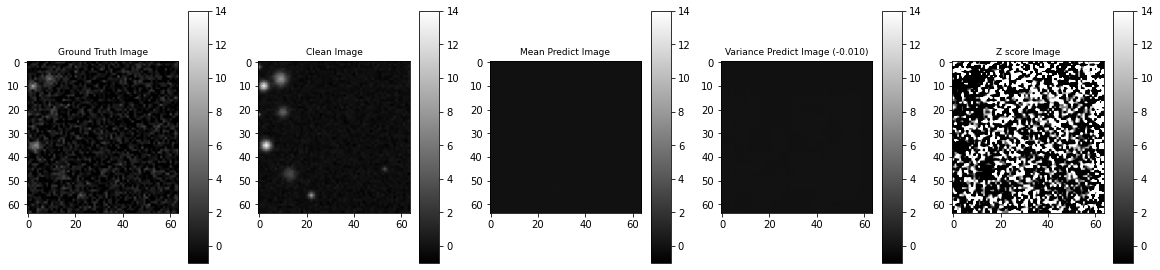

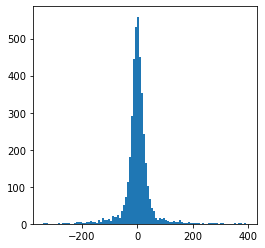

In [ ]:
# test denoising reconstruction

print('Compression ratio:', shape[0]*shape[1] / (8*8*encoding_filters[-1]))


vmin = -1
vmax = 14
num_tests = 1
for i in range(num_tests):
  index = random.randint(0, len(synth_test_noisy)-1)
  ground_truth_img = synth_test_noisy[index].reshape(shape)
  clean_img = synth_test[index].reshape(shape)
  test_img = synth_test_noisy[index].reshape(1,shape[0],shape[1],1)

  with tf.device(device_name = '/device:GPU:0'):
      mean_pred_img, var_pred_img = np.array(autoencoder_C.predict(test_img))
      mean_pred_img = mean_pred_img.reshape(shape)
      var_pred_img = var_pred_img.reshape(shape)

  print(np.shape(test_img))
  print(np.shape(mean_pred_img))

  mse = (np.array(mean_pred_img) - np.array(ground_truth_img))**2
  mse = np.mean(mse)

  Z_image = (np.array(mean_pred_img) - np.array(ground_truth_img))/(np.array(var_pred_img) + epsilon)

  # create a figure with multiple subplots
  fig, axs = plt.subplots(1, 5, figsize=(16, 10), gridspec_kw={'wspace': 0.0, 'hspace': 0.0},
                          constrained_layout=True)


  # plot each image on a separate subplot
  im0 = axs[0].imshow(ground_truth_img, cmap='gray', vmin = vmin, vmax = vmax)
  axs[0].set_title('Ground Truth Image', fontsize = 9)
  fig.colorbar(im0, ax=axs[0], shrink=0.35)

  im1 = axs[1].imshow(clean_img, cmap='gray', vmin = vmin, vmax = vmax)
  axs[1].set_title('Clean Image', fontsize = 9)
  fig.colorbar(im1, ax=axs[1], shrink=0.35)

  im2 = axs[2].imshow(mean_pred_img, cmap='gray', vmin = vmin, vmax = vmax)
  axs[2].set_title('Mean Predict Image', fontsize = 9)
  fig.colorbar(im2, ax=axs[2], shrink=0.35)

  im3 = axs[3].imshow(var_pred_img, cmap = 'gray', vmin = vmin, vmax = vmax)
  axs[3].set_title('Variance Predict Image (-{:.3f})'.format(epsilon), fontsize=9)
  fig.colorbar(im3, ax=axs[3], shrink=0.35)

  im4 = axs[4].imshow(Z_image, cmap = 'gray', vmin = vmin, vmax = vmax)
  axs[4].set_title('Z score Image' , fontsize=9)
  fig.colorbar(im4, ax=axs[4], shrink=0.35)

  # histogram of Z score
  image_flatten = np.array(Z_image).flatten()
  print('z_mean:', np.mean(image_flatten))
  print('z_std:', np.std(image_flatten))
  plt.figure(figsize = (4,4))
  histogram = plt.hist(image_flatten, density = False, bins = 100)





